In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score, make_scorer, confusion_matrix, accuracy_score

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

#  PART 1

In the first part of TP1 we pursue the following goals:
1. Apply standard ML algorithms on a standard benchmark data
2. Learn basic means of data visualizations
3. Get familiar with sklearn's GridSearchCV and Pipeline

# Loading the data

MNIST dataset consists of black and white images of hand-written digits from $0$ to $9$ of size $28 \times 28$.
In this exercise we will work with a small subset of the original MNIST dataset. 

If you are interested in the whole dataset, execute the following commands
```python
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=custom_data_home)
```

Hence, the observations $(X_1, Y_1), \ldots, (X_n, Y_n)$ are such that $X_i \in \mathbb{R}^{784}$ and $Y_i \in \{0, \ldots, 9\}$. To be more precise, each component of vector $X_i$ is a number between $0$ and $255$, which signifies the intensity of black color.

The initial goal is to build a classifier $\hat g$, which receives a new image $X$ and outputs the number that is present on the image.

In [2]:
X_train = np.load('mnist1_features_train.npy', allow_pickle=True)
y_train = np.load('mnist1_labels_train.npy', allow_pickle=True)
X_test = np.load('mnist1_features_test.npy', allow_pickle=True)
y_test = np.load('mnist1_labels_test.npy', allow_pickle=True)

n_samples, n_features = X_train.shape # extract dimensions of the design matrix
print('Train data contains: {} samples of dimension {}'.format(n_samples, n_features))
print('Test data contains: {} samples'.format(X_test.shape[0]))

Train data contains: 2000 samples of dimension 784
Test data contains: 200 samples


# Looking at the data

Since each observation is actually an image, we can visualize it.

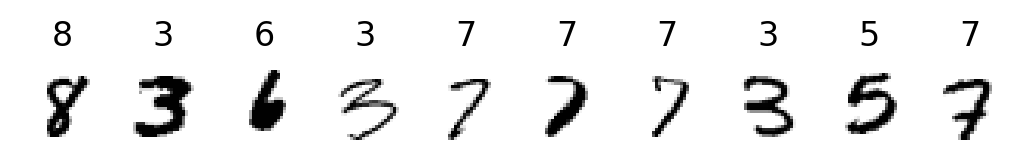

In [3]:
# Magic for backend switching
%matplotlib inline
axes = plt.subplots(1, 10)[1]  # creates a grid of 10 plots

# More details about zip() function here https://docs.python.org/3.3/library/functions.html#zip
images_and_labels = list(zip(X_train, y_train)) 
for ax, (image, label) in zip(axes, images_and_labels[:10]):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('{}'.format(label))

plt.show()

In [4]:
for i in range(10):
    print('Number of {}s in the train dataset is {}'.format(i, np.sum([y_train == str(i)])))

Number of 0s in the train dataset is 196
Number of 1s in the train dataset is 226
Number of 2s in the train dataset is 214
Number of 3s in the train dataset is 211
Number of 4s in the train dataset is 187
Number of 5s in the train dataset is 179
Number of 6s in the train dataset is 175
Number of 7s in the train dataset is 225
Number of 8s in the train dataset is 186
Number of 9s in the train dataset is 201


From the above we conclude that the dataset is rather balanced, that is, each class contains a similar number of observations. The most rare class is $y = 6$ with $175$ examples and the most common class is $y = 2$ with $226$ examples

# Cross-validation with GridSearchCV


**Question:** Explain in your report what happens when we run 
```python
clf.fit(X_train, y_train)
```

In [5]:
# GridSearchCV with kNN: a simple baseline
knn = KNeighborsClassifier() # defining classifier
parameters = {'n_neighbors': [1, 2, 3, 4, 5]} # defining parameter space
clf = GridSearchCV(knn, parameters, cv=3)
clf.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf.best_params_))
print('Best classification accuracy in train is: {}'.format(clf.best_score_))
print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Returned hyperparameter: {'n_neighbors': 1}
Best classification accuracy in train is: 0.891497944721333
Classification accuracy on test is: 0.875


**Answer:**
We are trying to find the best classifier among a given class of algorithms.
1. We select the class of kNN classifiers. Those predict the label of a given datapoint by identifying the most frequent label among the $k$ nearest points (majority voting) according to a distance function (by default the Euclidean distance). We need to find the optimal value of $k$, facing the classical trade-off between bias and variance, and also computational efficiency.
2. We define the values of $k$ we want to test, i.e., the parameter space.
3. We create a function that will determine the performance of the classifier for every value in the paramter space, using a 3-fold cross-validation (i.e., the sample will be splited in 3 folds, and the performance will be averaged using each of these folds as the test sample, and the remaining two as the training sample).
4. We perform the comparison and select the best model yielding the best accuracy on train (i.e., which has the higesht average share of correctly classified datapoints on average in the train samples). This is the operation done specifically by ```clf.fit(X_train, y_train)```.

The return hyperparameter is $k=1$, meaning that the best model consider only one nearest neighbor. Its performance is high, with an accuracy on test of 87,5 %, indicating that underfitting is unlikely. Additionally, its performance in train is similar, indicating that overfitting is also not likely.

**Question:** What is the test accuracy? What would be the accuracy of random guess?

**Answer:**
As said above, accuracy is a performance metric corresponding to the share of datapoints correctly classified. The sample is imbalanced, i.e., each class does not have the same frequency, but this cancels out in average, so that random accuracy is the reciprocal of the number of classes ($=1/10$). 


**Question:** What is ```LinearSVC()``` classifier? Which kernel are we using? What is ```C```? (this is a tricky question, try to find the answer online)

**Answer:**
LinearSVC stands for Linear Support Vector Classification, which is a subclass of Support Vector Machines (SVM). These classifiers are based on the max-margin principle: like the perceptron, they seek an hyperplane maximizing classes separation, but unlike the perceptron, they also yield the hyperplane maximizing the distance between classes. They use support vectors, meaning that they focus on the datapoints closest to the decision boundary, which makes them computationnaly efficient. When using kernel methods, they can also deal with non-separable data, by projecting it to a higher dimensional space where it becomes separable.

LinearSVC is an SVM algorithm dedicated to linear separation. It uses a linear kernel and $L2$ regularization, optimizing the following form: 
$$\min_ {w, b} \frac{1}{2} w^T w + C \sum_{i=1}^{n}\max(0, 1 - y_i (w^T \phi(x_i) + b))$$

$\phi()$ is the identity function. $C$ is a regularization parameter controlling the tradeoff between maximizing the separation between classes (i.e., the margin) and minimizing classification errors. Its default value is $1$. Decreasing $C$ yields a simpler model that better separates the classes, with an increased risk of underfitting, while increasing $C$ yields a more complex model that reduces classification error with an increased risk of overfitting.

**Question:** What is the outcome of ```np.logspace(-8, 8, 17, base=2)```? More generally, what is the outcome of ```np.logspace(-a, b, k, base=m)```?

In [6]:
np.logspace(-8, 8, 17, base=2)

array([3.90625e-03, 7.81250e-03, 1.56250e-02, 3.12500e-02, 6.25000e-02,
       1.25000e-01, 2.50000e-01, 5.00000e-01, 1.00000e+00, 2.00000e+00,
       4.00000e+00, 8.00000e+00, 1.60000e+01, 3.20000e+01, 6.40000e+01,
       1.28000e+02, 2.56000e+02])

**Answer:**
The ```np.logspace(-a, b, k, base=m)``` function generates $k$ evenly spaced numbers on a logarithmic scale between $-a$ and $b$ in base $m$. Thus, ```np.logspace(-8, 8, 17, base=2)``` generates $17$ evenly spaced numbers between $2^{-8}≈0,039$ and $2^8=256$.

In [7]:
# SVM Classifier
svc = LinearSVC(max_iter=5000, dual=True)
parameters2 = {'C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf2 = GridSearchCV(svc, parameters2, cv=3)
clf2.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf2.best_params_))
print('Best classification accuracy in train is: {}'.format(clf2.best_score_))
print('Classification accuracy on test is: {}'.format(clf2.score(X_test, y_test)))

/Users/mael/.pyenv/versions/3.10.14/envs/tensor/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mael/.pyenv/versions/3.10.14/envs/tensor/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mael/.pyenv/versions/3.10.14/envs/tensor/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mael/.pyenv/versions/3.10.14/envs/tensor/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mael/.pyenv/versions/3.10.14/envs/tensor/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of

Returned hyperparameter: {'C': 0.00390625}
Best classification accuracy in train is: 0.8095074084579332
Classification accuracy on test is: 0.795


/Users/mael/.pyenv/versions/3.10.14/envs/tensor/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**Question:** What is the meaning of the warnings? What is the parameter responsible for its appearence?

**Answer:** We are encountering a convergence issue. We could increase the number of iterations (```max_iter```) to give more room to the algorithm. If thas does not suffice, we could test lower regularization parameters $C$, or scale the features.

In [8]:
# SVM Classifier + Pipeline
pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', svc)])
parameters3 = {'svc__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf3 = GridSearchCV(pipe, parameters3, cv=3)
clf3.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf3.best_params_))
print('Best classification accuracy in train is: {}'.format(clf3.best_score_))
print('Classification accuracy on test is: {}'.format(clf3.score(X_test, y_test)))

Returned hyperparameter: {'svc__C': 0.015625}
Best classification accuracy in train is: 0.863002432717575
Classification accuracy on test is: 0.84


**Question:** What did we change with respect to the previous run of ```LinearSVC()```?

**Answer:**
We introduced scaling with the ```MaxAbsScaler()``` function. This allows the algorithm to converge within the definite number of iterations.

**Question:** Explain what happens if we execute
```python
    pipe.fit(X_train, y_train)
    pipe.predict(X_test, y_test)
```

**Answer:**
The code above yields an error because the ```predict()``` function does not accept a second argument for true labels. It simply computes predicted values. We should run instead:

```python
pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)
print(f'Classification accuracy on test is: {accuracy}')
```

This uses the ```score()``` function to compare the predicted labels with the true labels, so as to assess the predictive performance of the algorithm.

We assess that using a pipe should safeguard us against data leakage when scaling the data (which would happen if features of the train sample are scaled by maximum values found in the test sample).

In [9]:
# Logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=5000))])
parameters4 = {'logreg__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf4 = GridSearchCV(pipe, parameters4, cv=3)
clf4.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best classification accuracy in train is: {}'.format(clf4.best_score_))
print('Classification accuracy on test is: {}'.format(clf4.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.0078125}
Best classification accuracy in train is: 0.8710036873455165
Classification accuracy on test is: 0.84


**Question:** what is the difference between ```StandardScaler()``` and ```MaxAbsScaler()```? What are all scaling options available in ```sklearn```?

**Answer:**
```StandardScaler()``` is a normalizing function, which substracts the mean value then divide by the standard deviation. This ensures that each feature can contribute to the classification.

```MaxAbsScaler()``` is a scaling function to the $[-1,1]$ interval, which divides each by its maximum absolute value. It does not change the shape of the distribution, i.e., the mean does not become 0 and the relative distance between the datapoints remains the same. This is especially usefull when data is sparse and the sign of datapoints matters.

Other scaling options available in ```sklearn``` include:
- ```MinMaxScaler``` which allows scaling on a custom range (eg, $[0,1]$)
- ```RobustScaler``` which is a normalizing function using the median instead of the mean and the inter-quartile range instead of the standard deviation, to minimize the effect of outliers.
- ```QuantileTransformer``` which maps the data to a uniform distribution on $[0,1]$.
- ```PowerTransformer``` which maps the data to a Gaussian distribution. This helps stabilize variance and minimize skewness.

**Question:** using the previous code as an example achieve test accuracy $\geq 0.9$. You can use any method from sklearn package. Give a mathematical description of the selected method. Explain the range of considered hyperparameters.

**Answer:**
The algorithms reaching the highest prediction accuracy on the MNIST dataset are convolutional neural networks (CNN). For instance, the model described [here](https://www.kaggle.com/code/ahmed121ashraf131/mnist-simple-cnn-knn-accuracy-100-top-1) on Kaggle achieves a $99,87 \%$ accuracy. We have implemented and reached a $98,5 \%$ accuracy with the provided dataset and a $99,63 \%$ accuracy on the full MNIST dataset (see the annex, computation is quite long without GPU acceleration).

However, we believe the aim here is not to implement such a complex model, whose mathematical description would be very lengthy. Toying with the classifiers introduced above, we can achieve a $\geq 0.9$ test accuracy much more easily with the knn classifier. Two changes are necessary: making the parameter space start at 3 and introducing distance-based weights in the voting system. This ensures that multiple datapoints are used for prediction instead of just one as above, as the hyperparameter value returned was $1$, while mitigating the risk of overfitting by giving greater consideration to the closest datapoints. We achieve a $0,91$ test accuracy in this way.

Mathematically, the algorithm solves the following program:
- For each query point $q$, compute the distance to every data point $x_i$ in the dataset: $d(x_i, q) = \sqrt{\sum_{j=1}^{m} (x_{ij} - q_j)^2}$ (with an Euclidian distance function)
- Sort the distances $d(x_i, q)$ in ascending order, then select the $k$-closest neighbours.
- Assign a weight $w_i$ to each neighbor based on its distance to the query point $q$: $w_i = \frac{1}{d(x_i, q) + \varepsilon}$ (the constant $\varepsilon$ is introduced to avoid division by zero)
- Determine the predicted label $y_q$ based on the weighted majority vote: $y_q = \arg\max_y \sum_{i \in k\text{-neighbours}} w_i \cdot \mathbb{1}(y_i = y)$
- Repeat for every value of $k$ in the parameter space and select the one yielding the highest accuracy.

In [4]:
knn = KNeighborsClassifier()
parameters5 = {'n_neighbors': [3, 4, 5, 6, 7], 'weights': ['distance']}
clf5 = GridSearchCV(knn, parameters5, cv=3)
clf5.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf5.best_params_))
print('Best classification accuracy in train is: {}'.format(clf5.best_score_))
print('Classification accuracy on test is: {}'.format(clf5.score(X_test, y_test)))

Returned hyperparameter: {'n_neighbors': 4, 'weights': 'distance'}
Best classification accuracy in train is: 0.891496443970207
Classification accuracy on test is: 0.91


# Visualizing errors

Some ```sklearn``` methods are able to output probabilities ```predict_proba(X_test)```.

**Question:** There is a mistake in the following chunk of code. Fix it.

**Answer:**
<i>Not sure here, the code does run and the results seem coherent...</i>

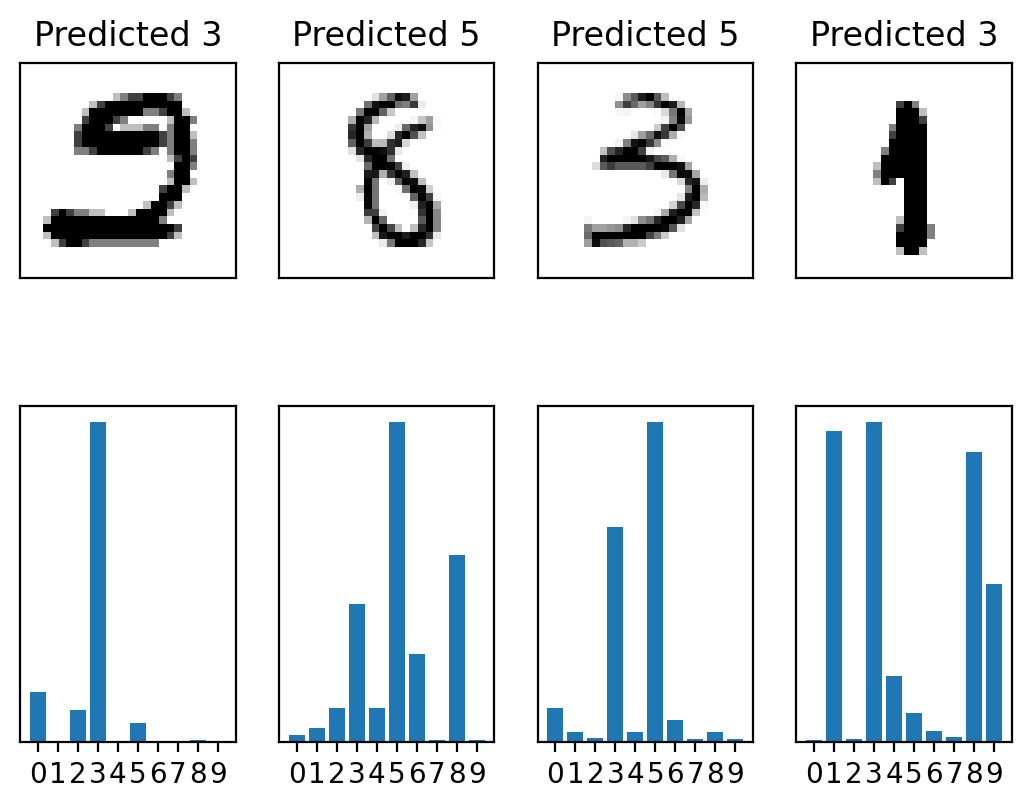

In [11]:
axes = plt.subplots(2, 4)[1] # creates a grid of 8 plots

# More details about zip() function here https://docs.python.org/3.3/library/functions.html#zip
y_pred = clf4.predict(X_test)
j = 0 # Index which iterates over plots
for true_label, pred_label, image in list(zip(y_test, y_pred, X_test)):
    if j == 4: # We only want to look at 4 first mistakes
        break
    if true_label != pred_label:
        # Plotting predicted probabilities
        axes[1, j].bar(np.arange(10), clf4.predict_proba(image.reshape(1, -1)).reshape(10)) # reshaping here
        axes[1, j].set_xticks(np.arange(10))
        axes[1, j].set_yticks([])
        
        # Plotting the image
        axes[0, j].imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
        axes[0, j].set_xticks([])
        axes[0, j].set_yticks([])
        axes[0, j].set_title('Predicted {}'.format(pred_label))
        j += 1

#         plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
#         axex[1, j].plot()

# Changing the Loss function

It often happens that the accuracy is not the right way to evaluate the performance. ```sklearn``` has a large variety of other metrics both in classification and regression. See https://scikit-learn.org/1.5/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

Here we want to understand how to change the cross-validation metric with minimal effort.

In [12]:
# SVM Classifier + Pipeline + New score function
pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', svc)])
parameters6 = {'svc__C': np.logspace(-8, 8, 17, base=2)}
balanced_scorer = make_scorer(balanced_accuracy_score)

clf6 = GridSearchCV(pipe, parameters6, cv=3, scoring=balanced_scorer)
clf6.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf6.best_params_))
print('Best Balanced accuracy in train is: {}'.format(clf6.best_score_))
print('Balanced accuracy on test is: {}'.format(clf6.score(X_test, y_test)))

Returned hyperparameter: {'svc__C': 0.015625}
Best Balanced accuracy in train is: 0.8612334093654231
Balanced accuracy on test is: 0.825627008328415


**Question:** What is ```balanced_accuracy_score```? Write its mathematical description.

**Answer:**
This metrics is defined as the average recall score per class. It adresses imbalances in datasets by avoiding situations where algorithms perform better on the most frequent classes. Let $N$ be the number of classes:

$$\texttt{balanced-accuracy} = \frac{1}{N} \sum_{i=1}^{N} \texttt{Recall}_i = \frac{1}{N} \sum_{i=1}^{N} \frac{\texttt{TP}_i}{\texttt{TP}_i+\texttt{FN}_i}$$

Sometimes it is important to look at the confusion matrix of the prediction.

**Question:** What is the confusion matrix? What are the conclusions that we can draw from the ```confusion_matrix(y_test, clf4.predict(X_test))```?

**Answer:**
The confusion matrix represent all possible outcomes of the classification process. It maps the actual classes (in rows) with the predicted classes (in columns). The cells represent the absolute number of datapoints corresponding to each outcome (e.g., if the value of the cell $[3,5]$ is $1$, exactly $1$ datapoint has a true label of $3$ and a predicted label of $5$). Correctly classified datapoints are found in the diagonal cells, misclassified datapoints in off-diagonal cells. Confusion matrixes are usefull to asses the performance of classification algorithms, by revealing the cases where they perform poorly.


Regarding our logistic regression, its performs notably worse for the $4$ and $8$ classes, which are among the less frequent in the test dataset and also the most often misclassified. To improve this algorithm, we could thus focus on these two classes.

In [13]:
print(confusion_matrix(y_test, clf4.predict(X_test)))

[[22  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  3  0  0  0  0  2  0]
 [ 0  0 13  1  1  0  1  0  0  0]
 [ 0  0  1 17  0  3  0  0  1  1]
 [ 0  1  0  0 18  0  0  0  0  1]
 [ 1  0  0  0  0  8  0  1  0  0]
 [ 1  1  1  0  0  0 20  0  1  0]
 [ 0  0  0  0  1  0  0 14  0  1]
 [ 0  2  0  1  0  3  0  0 11  0]
 [ 0  0  0  0  0  0  0  2  0 24]]
